In [4]:
import os
from dask import persist
import dask.dataframe as df
from operator import add
from dask.distributed import Client
import matplotlib.pyplot as plt
from functools import reduce

head, tail = os.path.split(os.getcwd())
data_dir = os.path.join(head, 'data')
data_raw_dir = os.path.join(data_dir, 'raw')

In [5]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:58293")
client

Client Scheduler: tcp://127.0.0.1:58293 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 8 Memory: 17.18 GB


In [6]:
def assignCentroid(row, centroids):
    c = reduce((lambda a,b: a if a[1]<b[1] else b),[(centroids.name,(row.nLongitude-centroids.nLongitude)**2 + (row.nLatitude-centroids.nLatitude)**2) for centroids in centroids.itertuples()]) 
    return  c[0]

# Loading data

In [7]:
park_spot_data = df.read_csv(os.path.join(data_raw_dir, 'Places.csv'), 
                             encoding='cp1252', blocksize='512KiB')[['sNoPlace','nLongitude','nLatitude']]

list_of_borough =['Plateau-Mont-Royal',
                  'Saint-Léonard',
                  'Rosemont - La Petite-Patrie',
                  'Outremont',
                  'Ville-Marie',
                  'Mercier - Hochelaga-Maisonneuve',
                  'LaSalle',
                  'Villeray - Saint-Michel - Parc-Extension',
                  'Rivière-des-Prairies - Pointe-aux-Trembles',
                  'Côte-des-Neiges - Notre-Dame-de-Grâce',
                  'Lachine',
                  'Saint-Laurent',
                  'Ahuntsic - Cartierville',
                  'Sud-Ouest',
                  'Anjou',
                  'Montréal-Nord',
                  'Verdun',
                  'Pierrefonds - Roxboro']


# Initializing centroids randomly

In [8]:
init_centroids = park_spot_data.sample(frac=0.002).head(len(list_of_borough),npartitions=-1)

In [9]:
centroids = init_centroids.reset_index(drop=True).rename(columns={'sNoPlace':'name'})

In [10]:
park_spot_data['centroids']=''
epoch=0

# Fitting loop

In [11]:
while True:
    epoch+=1
    park_spot_data['new_centroids'] = park_spot_data.apply(assignCentroid, axis=1, args=(centroids,), meta=('centroid', 'f8'))
    park_spot_data = park_spot_data.persist()
    spot_changed_number =len(park_spot_data[park_spot_data['centroids']!=park_spot_data['new_centroids']])
    print('Epoch ',epoch,':',spot_changed_number)
    if spot_changed_number==0:
        break
    centroids = park_spot_data[['nLongitude','nLatitude','new_centroids']].groupby('new_centroids').mean().reset_index().rename(columns={'new_centroids':'name'})
    centroids = centroids.persist()
    park_spot_data['centroids']=park_spot_data['new_centroids']
    

Epoch  1 : 18652
Epoch  2 : 4986
Epoch  3 : 2455
Epoch  4 : 2019
Epoch  5 : 1253
Epoch  6 : 893
Epoch  7 : 789
Epoch  8 : 852
Epoch  9 : 809
Epoch  10 : 970
Epoch  11 : 882
Epoch  12 : 808
Epoch  13 : 888
Epoch  14 : 799
Epoch  15 : 838
Epoch  16 : 577
Epoch  17 : 415
Epoch  18 : 281
Epoch  19 : 232
Epoch  20 : 191
Epoch  21 : 144
Epoch  22 : 124
Epoch  23 : 91
Epoch  24 : 70
Epoch  25 : 46
Epoch  26 : 47
Epoch  27 : 28
Epoch  28 : 24
Epoch  29 : 23
Epoch  30 : 20
Epoch  31 : 11
Epoch  32 : 12
Epoch  33 : 9
Epoch  34 : 12
Epoch  35 : 10
Epoch  36 : 7
Epoch  37 : 9
Epoch  38 : 5
Epoch  39 : 1
Epoch  40 : 3
Epoch  41 : 7
Epoch  42 : 5
Epoch  43 : 9
Epoch  44 : 8
Epoch  45 : 12
Epoch  46 : 3
Epoch  47 : 2
Epoch  48 : 2
Epoch  49 : 1
Epoch  50 : 0


# Plotting the result

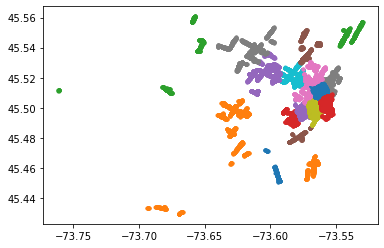

In [19]:
groups = df.groupby('centroids')

for name, group in groups:
    plt.plot(group.nLongitude, group.nLatitude, marker='.', linestyle='',  label=name)
